In [3]:
import geopandas as gpd
import rasterio
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from rasterio.warp import transform_bounds
from tile_mate import get_raster_from_tiles
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np
from rasterio.transform import xy
from shapely.geometry import Point
from rasterio.plot import show

In [4]:
BURST_ID = 'T064_135519_IW1'

In [5]:
ts_dir = Path('burst_time_series')
burst_dir = ts_dir / BURST_ID
assert burst_dir.exists()

In [6]:
df_meta = gpd.read_file(burst_dir / f'metadata_{BURST_ID}_rtc_ts.geojson')
df_meta.head()

,opera_id,start_time,url_vh,url_vv,track_number,local_path_vv,local_path_vh,geometry
0,OPERA_L2_RTC-S1_T064-135519-IW1_20200229T01502...,2020-02-29 01:50:24+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135519_IW1/OPERA_L2_RTC...,burst_time_series/T064_135519_IW1/OPERA_L2_RTC...,"POLYGON ((-118.81613 33.84621, -117.87204 33.9..."
1,OPERA_L2_RTC-S1_T064-135519-IW1_20200312T01502...,2020-03-12 01:50:24+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135519_IW1/OPERA_L2_RTC...,burst_time_series/T064_135519_IW1/OPERA_L2_RTC...,"POLYGON ((-118.81680 33.84657, -117.87274 33.9..."
2,OPERA_L2_RTC-S1_T064-135519-IW1_20200324T01502...,2020-03-24 01:50:24+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135519_IW1/OPERA_L2_RTC...,burst_time_series/T064_135519_IW1/OPERA_L2_RTC...,"POLYGON ((-118.81621 33.84597, -117.87213 33.9..."
3,OPERA_L2_RTC-S1_T064-135519-IW1_20200417T01502...,2020-04-17 01:50:25+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135519_IW1/OPERA_L2_RTC...,burst_time_series/T064_135519_IW1/OPERA_L2_RTC...,"POLYGON ((-118.81590 33.84643, -117.87199 33.9..."
4,OPERA_L2_RTC-S1_T064-135519-IW1_20200429T01502...,2020-04-29 01:50:26+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135519_IW1/OPERA_L2_RTC...,burst_time_series/T064_135519_IW1/OPERA_L2_RTC...,"POLYGON ((-118.81594 33.84618, -117.87201 33.9..."


Sanity check

In [7]:
def get_trans_and_shape(path: str) -> tuple:
    with rasterio.open(path) as ds:
        t = ds.transform
        s = ds.shape
    return t, s

data = [get_trans_and_shape(path) for path in df_meta.local_path_vh.tolist()]
unique_date = list(set(data))
unique_date

[(Affine(30.0, 0.0, 323100.0,
         0.0, -30.0, 3787950.0),
  (1565, 3307))]

In [8]:
with rasterio.open(df_meta.local_path_vh.tolist()[0]) as ds:
    p_rtc = ds.profile
    bounds = ds.bounds
bounds, p_rtc

(BoundingBox(left=323100.0, bottom=3741000.0, right=422310.0, top=3787950.0),
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 3307, 'height': 1565, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 323100.0,
        0.0, -30.0, 3787950.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'})

In [11]:
bounds_4326 = transform_bounds(p_rtc['crs'], CRS.from_epsg(4326), *bounds)
bounds_4326

(-118.92036109422698,
 33.794391298946955,
 -117.83936426571901,
 34.22972841668213)

# Generate Pekel Water Mask

In [12]:
X_occ, p_occ = get_raster_from_tiles(bounds_4326, 'pekel_water_occ_2021')

Reading tile imagery: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


In [13]:
X_occ = X_occ.astype(np.float32)
p_occ['dtype'] = 'float32'
X_occ_r, _ = reproject_arr_to_match_profile(X_occ, p_occ, p_rtc, resampling='bilinear')

In [14]:
WATER_MASK = (X_occ_r > 95)[0, ...]

In [15]:
p_wtr = p_occ.copy()
p_wtr['dtype'] = np.uint
with rasterio.open(ts_dir / 'water_mask.tif', 'w', **p_wtr) as ds:
    ds.write(WATER_MASK.astype('uint8'), 1)

# Load Time Series

In [16]:
def open_one(path: str) -> tuple:
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    X[WATER_MASK] = np.nan
    ## Clip
    if '_VV.tif' == path[-7:]:
        X = np.clip(X, 0, 1)
    else:
        X = np.clip(X, 0, .5)
    return X, p

In [17]:
arrs_vv, profiles = zip(*[open_one(p) for p in tqdm(df_meta.local_path_vv)])
arrs_vh, _ = zip(*[open_one(p) for p in tqdm(df_meta.local_path_vh)])

100%|██████████████████████████████████████████████████████████████████| 115/115 [00:08<00:00, 13.27it/s]


In [18]:
acq_dt = df_meta.start_time.tolist()
acq_dt[:2]

[Timestamp('2020-02-29 01:50:24+0000', tz='UTC'),
 Timestamp('2020-03-12 01:50:24+0000', tz='UTC')]

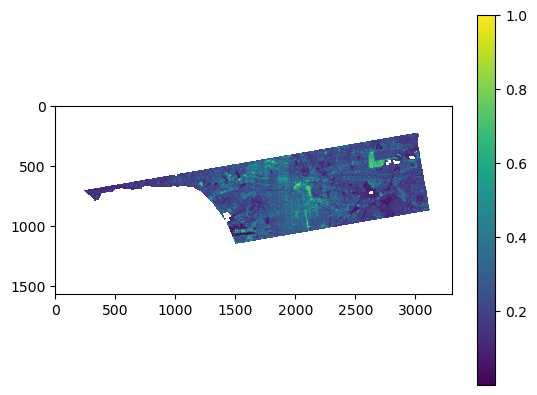

In [21]:
plt.imshow(arrs_vv[0])
plt.colorbar()

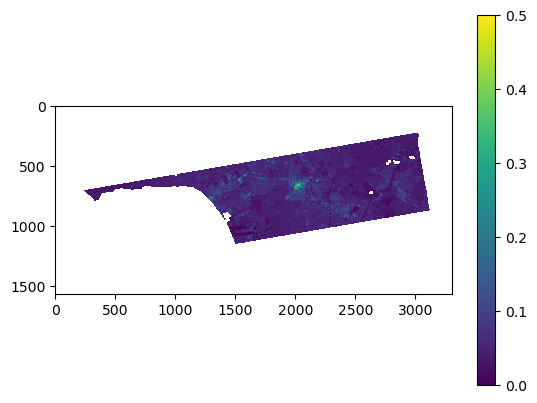

In [24]:
plt.imshow(arrs_vh[0])
plt.colorbar()

In [25]:
X_vv_samp = arrs_vv[0]
RTC_MASK = np.isnan(X_vv_samp)

In [26]:
rows, cols = np.where(~RTC_MASK)

X_vv_samp[rows[100], cols[100]]

0.38385057

# Sample a Pixel

In [200]:
np.random.seed(0)
N_SAMPLES = 1000

In [201]:
N = 33
assert N < N_SAMPLES

In [202]:
K = np.random.randint(len(rows), size=100)[N]
m, n = rows[K], cols[K]

arrs_vv[0][m, n]

0.19725461

## Visualize Sampled Pixel on Map

In [203]:
c_x, c_y = xy(p_rtc['transform'], m, n)
c_x, c_y

(378165.0, 3766635.0)

In [204]:
df_aoi_utm = gpd.GeoDataFrame(geometry=[Point(c_x, c_y)],
                              crs=p_rtc['crs'])
df_aoi_utm.head()

,geometry
0,POINT (378165.000 3766635.000)


<Axes: >

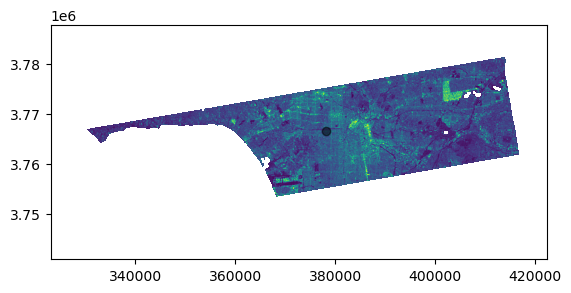

In [205]:
fig, ax = plt.subplots()

show(arrs_vv[0], transform=p_rtc['transform'], ax=ax)
df_aoi_utm.plot(ax=ax, alpha=.5, color='black')

# Visualize Time Series at Point

In [206]:
ws = 5
assert (ws % 2) == 1

In [207]:
m - ws // 2, m, m + ws // 2 + 1

(708, 710, 713)

In [208]:
ind_y = np.s_[m - ws // 2: m + ws // 2 + 1]
ind_x = np.s_[n - ws // 2: n + ws // 2 + 1]

vv_ts_mu = np.array([np.nanmean(arr[ind_y, ind_x]) for arr in arrs_vv])
vv_ts_std = np.array([np.nanstd(arr[ind_y, ind_x]) for arr in arrs_vv])

vh_ts_mu = np.array([np.nanmean(arr[ind_y, ind_x]) for arr in arrs_vh])
vh_ts_std = np.array([np.nanstd(arr[ind_y, ind_x]) for arr in arrs_vh])

Text(0.5, 1.0, 'VH')

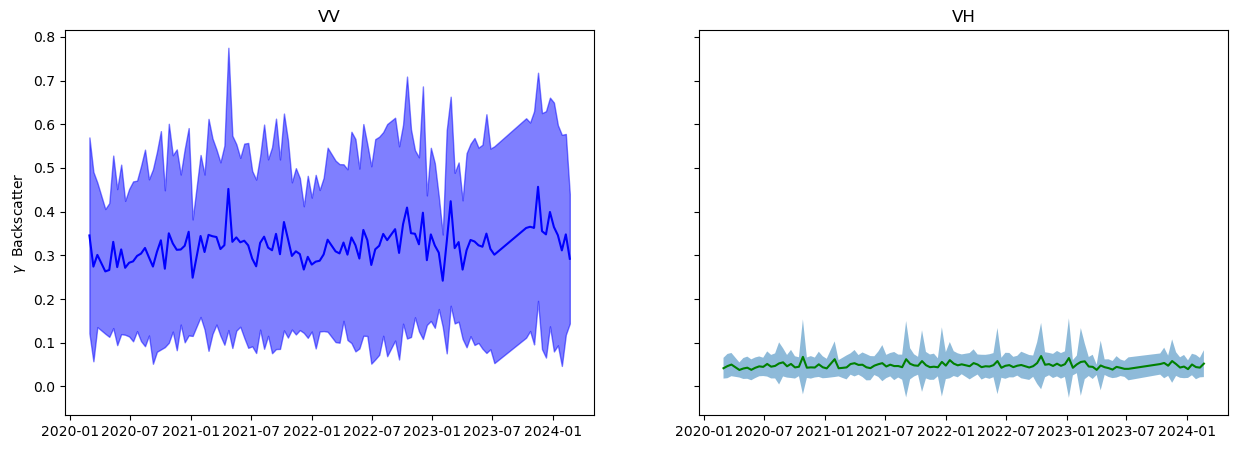

In [209]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

axs[0].plot(acq_dt, vv_ts_mu, color='blue')
axs[0].fill_between(acq_dt, vv_ts_mu - vv_ts_std, vv_ts_mu + vv_ts_std, alpha=.5, color='blue') 
axs[0].set_ylabel('$\\gamma$  Backscatter')
axs[0].set_title('VV')

axs[1].plot(acq_dt, vh_ts_mu, color='green')
axs[1].fill_between(acq_dt, vh_ts_mu - vh_ts_std, vh_ts_mu + vh_ts_std, alpha=.5)
axs[1].set_title('VH')

## Qualitative Stats Change Measure

Text(0.5, 1.0, 'VV')

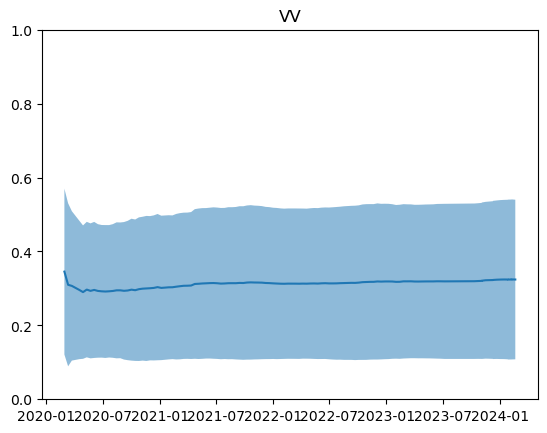

In [211]:
n = len(acq_dt)
vv_ts_mu_running = np.cumsum(vv_ts_mu) / (np.arange(n) + 1)
vv_ts_std_running = np.cumsum(vv_ts_std) / (np.arange(n) + 1)

plt.fill_between(acq_dt, vv_ts_mu_running - vv_ts_std_running, vv_ts_mu_running + vv_ts_std_running, alpha=.5)
plt.plot(acq_dt, vv_ts_mu_running)
plt.ylim(0, 1)
plt.title('VV')

Text(0.5, 1.0, 'VH')

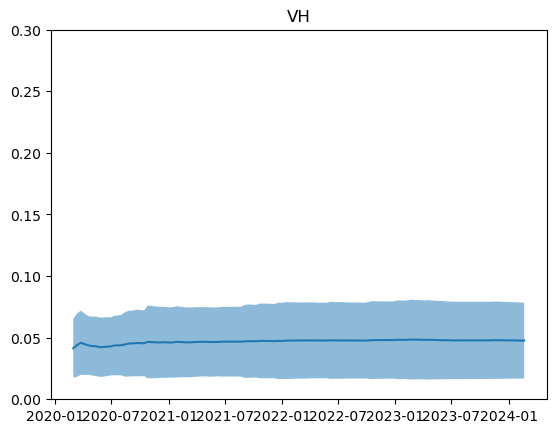

In [212]:
n = len(acq_dt)
vh_ts_mu_running = np.cumsum(vh_ts_mu) / (np.arange(n) + 1)
vh_ts_std_running = np.cumsum(vh_ts_std) / (np.arange(n) + 1)

plt.fill_between(acq_dt, vh_ts_mu_running - vh_ts_std_running, vh_ts_mu_running + vh_ts_std_running, alpha=.5)
plt.plot(acq_dt, vh_ts_mu_running)
plt.ylim(0, .3)
plt.title('VH')

# Time Series by Land Cover

In [213]:
X_lc, p_lc = get_raster_from_tiles(bounds_4326, tile_shortname='esa_world_cover_2021')

Reading tile imagery: 100%|████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


In [214]:
p_dst = p_wtr.copy()
#p_dst['nodata'] = p_lc['nodata']
#p_dst['dtype'] = np.uint8

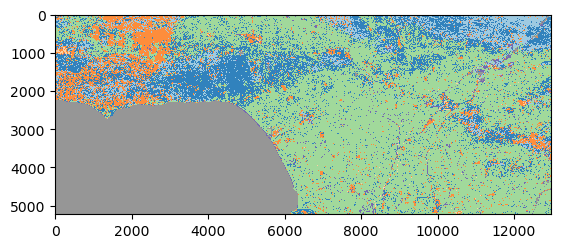

In [215]:
plt.imshow(X_lc[0, ...], cmap='tab20c', interpolation='None')

## Digression into Upsampling Multiple Classes

In [216]:
tags = p_lc['tags']
tags

{'algorithm_version': 'V2.0.0',
 'AREA_OR_POINT': 'Area',
 'copyright': 'ESA WorldCover project 2021 / Contains modified Copernicus Sentinel data (2021) processed by ESA WorldCover consortium',
 'creation_time': '2022-10-21 07:35:40.236136',
 'legend': '10  Tree cover\n20  Shrubland\n30  Grassland\n40  Cropland\n50  Built-up\n60  Bare/sparse vegetation\n70  Snow and ice\n80  Permanent water bodies\n90  Herbaceous wetland\n95  Mangroves\n100 Moss and lichen\n',
 'license': 'CC-BY 4.0 - https://creativecommons.org/licenses/by/4.0/',
 'product_crs': 'EPSG:4326',
 'product_grid': '3x3 degree tiling grid',
 'product_tile': 'S54E168',
 'product_type': 'LandCover Map',
 'product_version': 'V2.0.0',
 'reference': 'https://esa-worldcover.org',
 'time_end': '2021-12-31T23:59:59Z',
 'time_start': '2021-01-01T00:00:00Z',
 'title': 'ESA WorldCover product at 10m resolution for year 2021'}

In [217]:
label2class = {int(item.split()[0]): item.split()[1] for item in tags['legend'].split('\n') if item}
label2class

{10: 'Tree',
 20: 'Shrubland',
 30: 'Grassland',
 40: 'Cropland',
 50: 'Built-up',
 60: 'Bare/sparse',
 70: 'Snow',
 80: 'Permanent',
 90: 'Herbaceous',
 95: 'Mangroves',
 100: 'Moss'}

In [109]:
n_labels = len(label2class)
percent_mat = np.zeros((n_labels, p_rtc['height'], p_rtc['width']))
p_perc = p_lc.copy()
p_perc['dtype'] = 'float32'

for ind, (k, label) in enumerate(tqdm(label2class.items())):
    bin_arr = (X_lc == k).astype(np.float32)
    bin_arr_r, _ = reproject_arr_to_match_profile(bin_arr, p_perc, p_rtc, resampling='average')
    bin_arr_r = bin_arr_r[0, ...]
    percent_mat[ind, ...] = bin_arr_r

100%|████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.92it/s]


In [110]:
max_label = np.argmax(percent_mat, axis=0)
max_label.shape, max_label

((1565, 3307),
 array([[1, 1, 0, ..., 5, 5, 7],
        [1, 1, 0, ..., 7, 5, 7],
        [1, 0, 1, ..., 7, 5, 5],
        ...,
        [7, 7, 7, ..., 4, 4, 4],
        [7, 7, 7, ..., 4, 4, 4],
        [7, 7, 7, ..., 4, 4, 4]]))

In [155]:
ind2label = {i: l for (i, l) in enumerate(label2class.keys())}
ind2label

{0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 70, 7: 80, 8: 90, 9: 95, 10: 100}

In [156]:
X_lc_r = np.zeros((p_rtc['height'], p_rtc['width']))
for ind, l in ind2class.items():
    X_lc_r[max_label == ind] = l
X_lc_r.shape, arrs_vh[0].shape

((1565, 3307), (1565, 3307))

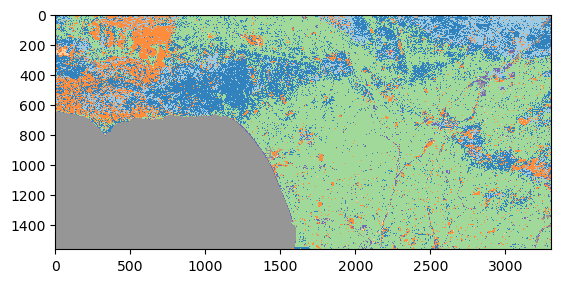

In [157]:
plt.imshow(X_lc_r, cmap='tab20c', interpolation='none')

## Plotting by LC class

In [174]:
label_2_vv_ts_mean = {}
label_2_vv_ts_std = {}

label_2_vh_ts_mean = {}
label_2_vh_ts_std = {}

for l, cl in tqdm(label2class.items()):
    label_mask = (X_lc_r == l)
    if np.sum(label_mask):
        label_2_vv_ts_mean[l] = np.array([np.nanmean(arr[label_mask]) for arr in arrs_vv])
        label_2_vv_ts_std[l] = np.array([np.nanstd(arr[label_mask]) for arr in arrs_vv])
    
        label_2_vh_ts_mean[l] = np.array([np.nanmean(arr[label_mask]) for arr in arrs_vh])
        label_2_vh_ts_std[l] = np.array([np.nanstd(arr[label_mask]) for arr in arrs_vh])

100%|████████████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.31s/it]


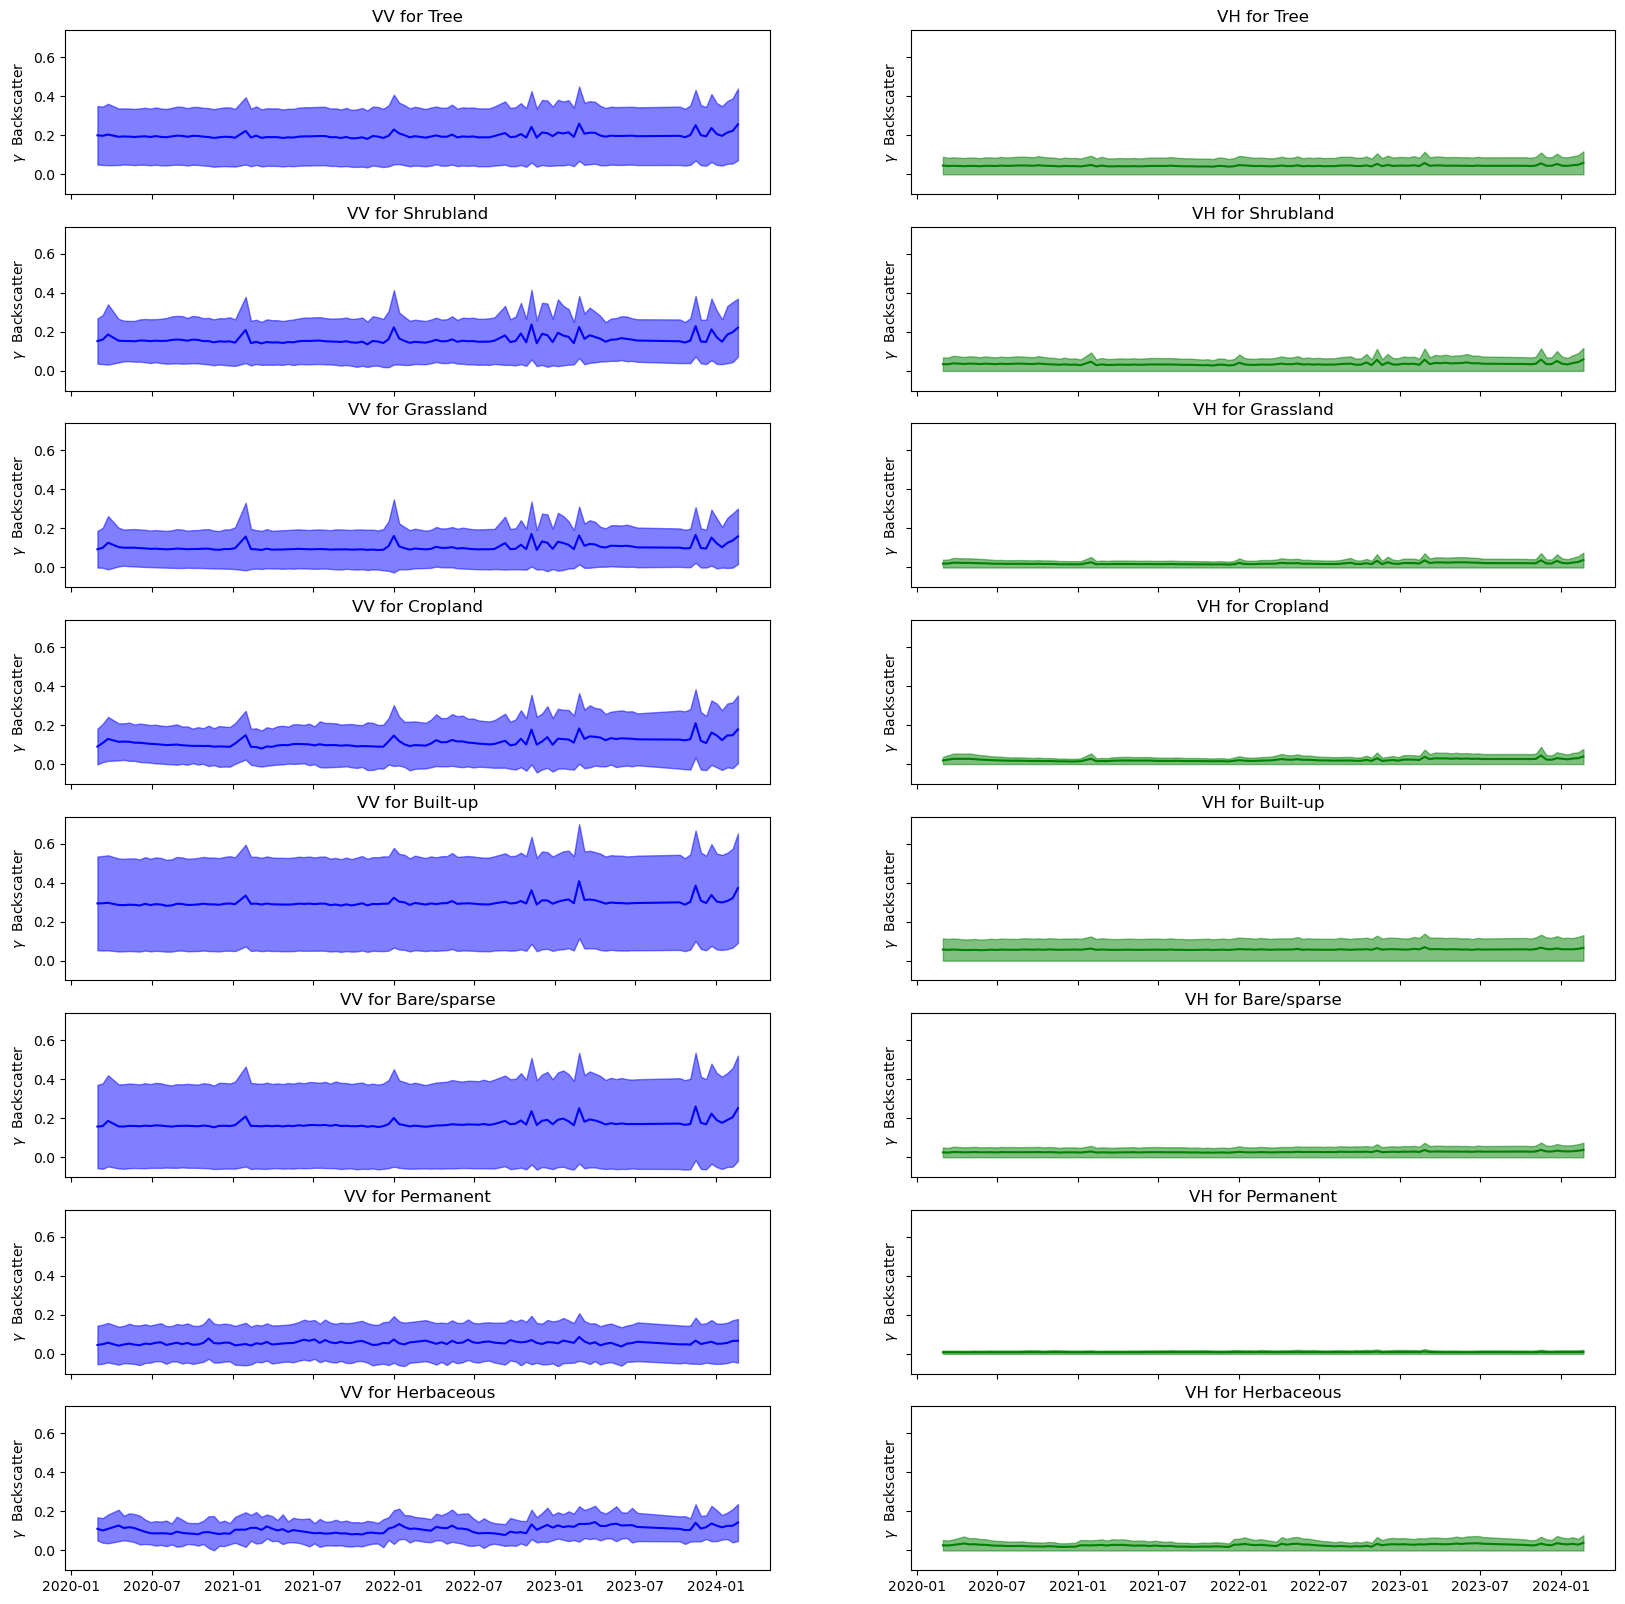

In [176]:
n_class_in_img = len(label_2_vv_ts_mean)
fig, axs = plt.subplots(n_class_in_img, 2, sharey=True, sharex=True, figsize=(20, 20))

for k, (label, vv_ts_mean) in enumerate(label_2_vv_ts_mean.items()):
    axs[k, 0].plot(acq_dt, vv_ts_mean, color='blue')

    vv_ts_std = label_2_vv_ts_std[label]
    axs[k, 0].fill_between(acq_dt, vv_ts_mean - vv_ts_std, vv_ts_mean + vv_ts_std, alpha=.5, color='blue') 
    
    axs[k, 0].set_ylabel('$\\gamma$  Backscatter')
    axs[k, 0].set_title(f'VV for {label2class[label]}')

    vh_ts_mean = label_2_vh_ts_mean[label]
    axs[k, 1].plot(acq_dt, vh_ts_mean, color='green')

    vh_ts_std = label_2_vh_ts_std[label]
    axs[k, 1].fill_between(acq_dt, vh_ts_mean - vh_ts_mean, vh_ts_mean + vh_ts_mean, alpha=.5, color='green') 
    
    axs[k, 1].set_ylabel('$\\gamma$  Backscatter')
    axs[k, 1].set_title(f'VH for {label2class[label]}')